In [1]:
import matplotlib.pyplot as plt 
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pandas as pd
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split

In [2]:
from wordcloud import WordCloud

In [3]:
df = pd.read_csv("review_data.csv")

In [4]:
df.head()

,title,reviewer_name,num_reviews,num_followers,star_rating,review_text,num_likes,num_comments
0,The Stolen Heir,Emily May,"2,031",310k,4.0,Not quite The Cruel Prince but I enjoyed this ...,"1,206",3.0
1,The Stolen Heir,jessica,"2,563",42.2k,4.0,hmm. i didnt obsess over this one like i did w...,654,0.0
2,The Stolen Heir,katia,306,526,3.0,"3.5 ★oak was a disappointment, but suren!! i l...","1,233",0.0
3,The Stolen Heir,cor,269,74,NaN,OMG IM SHAKING IM SO EXCITED IM GOING TO CRY I...,610,0.0
4,The Stolen Heir,ale (semi hiatus) ‧ ₊˚୨ ♡ ୧ ₊˚,438,"2,598",NaN,"WE HAVE A COVER, OMG, WE HAVE A COVER!!!!I NEE...",746,0.0


In [5]:
df_cleaned = df.dropna(subset=["star_rating","review_text"])

In [6]:
df.shape

(8399, 8)

In [7]:
df_cleaned.shape

(7850, 8)

Number of rows per star rating:
1    3271
2    2733
0    1209
Name: sentiment, dtype: int64


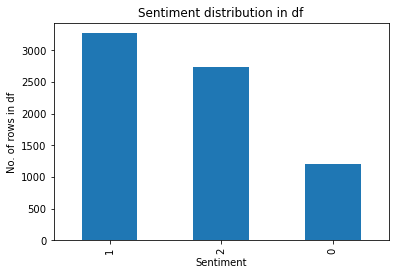

In [25]:
# Function to map stars to sentiment
def map_sentiment(stars_received):
    if stars_received <= 2:
        return 0
    elif stars_received <= 4:
        return 1
    else:
        return 2
# Mapping stars to sentiment into three categories
df_cleaned['sentiment'] = [ map_sentiment(x) for x in df_cleaned['star_rating']]
print("Number of rows per star rating:")
print(df_cleaned['sentiment'].value_counts())

# Plotting the sentiment distribution
plt.figure()
pd.value_counts(df_cleaned['sentiment']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()

In [26]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    # Return the list of words separated by commas
    return ','.join(tokens)

# Apply the preprocess_text function to the "review_text" column
df_cleaned["cleaned_text"] = df_cleaned["review_text"].apply(preprocess_text)

# Drop rows with NaN values in the "cleaned_text" column
df_cleaned = df_cleaned.dropna(subset=["cleaned_text"])

# Check for foreign characters using a regular expression
df_cleaned = df_cleaned[df_cleaned["cleaned_text"].str.match(r'^[a-zA-Z\s,]+$')]

# Reset index after removing rows
df_cleaned.reset_index(drop=True, inplace=True)


In [27]:
df_cleaned["cleaned_text"].head()

0    quit,cruel,princ,enjoy,loti,love,back,world,lo...
1    hmm,didnt,obsess,one,like,origin,trilogywhil,e...
2    oak,disappoint,suren,love,much,cant,pretend,do...
3                everi,singl,mention,oak,hoov,jumpscar
4                                                 star
Name: cleaned_text, dtype: object

In [28]:
df_cleaned.head()

,title,reviewer_name,num_reviews,num_followers,star_rating,review_text,num_likes,num_comments,sentiment,cleaned_text
0,The Stolen Heir,Emily May,"2,031",310k,4.0,Not quite The Cruel Prince but I enjoyed this ...,"1,206",3.0,1,"quit,cruel,princ,enjoy,loti,love,back,world,lo..."
1,The Stolen Heir,jessica,"2,563",42.2k,4.0,hmm. i didnt obsess over this one like i did w...,654,0.0,1,"hmm,didnt,obsess,one,like,origin,trilogywhil,e..."
2,The Stolen Heir,katia,306,526,3.0,"3.5 ★oak was a disappointment, but suren!! i l...","1,233",0.0,1,"oak,disappoint,suren,love,much,cant,pretend,do..."
3,The Stolen Heir,madeline,111,18,3.0,Every single mention of Oak’s hooves was a jum...,"1,707",4.0,1,"everi,singl,mention,oak,hoov,jumpscar"
4,The Stolen Heir,Haley pham,81,143k,4.0,4.5 stars ⭐️🧚🏻🥹,"1,432",0.0,1,star


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [30]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from sklearn.preprocessing import StandardScaler

# Assuming you have a DataFrame df_cleaned with columns 'cleaned_text' and 'sentiment'
# Replace 'your_dataset.csv' with the actual file or provide your own dataset
# df_cleaned = pd.read_csv('your_dataset.csv')

# Split the dataset into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(df_cleaned['cleaned_text'], df_cleaned['sentiment'], test_size=0.2, random_state=42)

# Tokenize the text data
tokenized_train_data = [text.split(',') for text in train_data]
tokenized_test_data = [text.split(',') for text in test_data]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_train_data, vector_size=300, window=5, min_count=1, workers=4, sg=0)

# Create average word vectors for each document
def average_word_vectors(words, model, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in model.wv.index_to_key:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector

# Create document vectors for the training set
X_train = np.vstack([average_word_vectors(words, word2vec_model, 300) for words in tokenized_train_data])

# Create document vectors for the test set
X_test = np.vstack([average_word_vectors(words, word2vec_model, 300) for words in tokenized_test_data])

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [22]:
# Create and train the logistic regression model with increased max_iter
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, train_labels)

# Make predictions on the test set
predictions = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(test_labels, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print("Classification Report:\n", classification_report(test_labels, predictions))

Accuracy: 0.58
Classification Report:
               precision    recall  f1-score   support

          -1       0.61      0.30      0.40       259
           0       0.56      0.67      0.61       658
           1       0.60      0.61      0.61       526

    accuracy                           0.58      1443
   macro avg       0.59      0.53      0.54      1443
weighted avg       0.59      0.58      0.57      1443



In [31]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# Train XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_scaled, train_labels)

# Make predictions on the test set
predictions = xgb_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(test_labels, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print("Classification Report:\n", classification_report(test_labels, predictions))


Accuracy: 0.56
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.31      0.39       259
           1       0.56      0.63      0.59       658
           2       0.57      0.60      0.58       526

    accuracy                           0.56      1443
   macro avg       0.55      0.51      0.52      1443
weighted avg       0.56      0.56      0.55      1443



In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler

# Assuming you have a DataFrame df_cleaned with columns 'cleaned_text' and 'sentiment'
# Replace 'your_dataset.csv' with the actual file or provide your own dataset
# df_cleaned = pd.read_csv('your_dataset.csv')

# Split the dataset into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(df_cleaned['cleaned_text'], df_cleaned['sentiment'], test_size=0.2, random_state=42)

# Tokenize the text data
tokenized_train_data = [text.split(',') for text in train_data]
tokenized_test_data = [text.split(',') for text in test_data]

# Assuming you have already trained Word2Vec and created document vectors X_train and X_test
# ... (as per your previous code)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_scaled, train_labels)

# Make predictions on the test set
predictions = logistic_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(test_labels, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print("Classification Report:\n", classification_report(test_labels, predictions))


Accuracy: 0.58
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.31      0.41       259
           1       0.56      0.66      0.60       658
           2       0.60      0.61      0.60       526

    accuracy                           0.58      1443
   macro avg       0.58      0.53      0.54      1443
weighted avg       0.58      0.58      0.57      1443



/Users/blankajarmoszko/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
